In [ ]:
### Opening nxs

import h5py
import numpy as np
import napari

def find_datasets_with_dim_3(file, group=None, path="", results=None):
    """
    Find all datasets with 3 dimensions in a HDF5 file.       
    """
    if results is None:
        results = []

    if group is None:
        group = file

    for key in group:
        item = group[key]
        current_path = f"{path}/{key}"
        if isinstance(item, h5py.Group):
            find_datasets_with_dim_3(
                file, group=item, path=current_path, results=results
            )
        elif isinstance(item, h5py.Dataset):
            if len(item.shape) == 3:
                results.append(
                    (current_path, item.shape)
                ) 
    return results

projs_path = r"D:\SOLEIL25\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d.nxs"
dark_path = r"D:\SOLEIL25\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d\post_dark.nxs"
flat_paths = [r"D:\SOLEIL25\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d\post_ref.nxs", 
              r"D:\SOLEIL25\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d\pre_ref.nxs"]

with h5py.File(projs_path, 'r') as file:
    projs_key = find_datasets_with_dim_3(file)[0][0]
    projs = np.array(file[projs_key])
print("Projections shape:", projs.shape)

with h5py.File(dark_path, 'r') as file:
    dark_key = find_datasets_with_dim_3(file)[0][0]
    dark = np.mean(np.array(file[dark_key]), axis=0)
print("Dark shape:", dark.shape)

flat = []
for path in flat_paths:
    with h5py.File(path, 'r') as file:
        flat_key = find_datasets_with_dim_3(file)[0][0]
        flat.append(np.mean(np.array(file[flat_key]), axis=0))
flat = np.mean(np.array(flat), axis=0)
print("Flat shape:", flat.shape)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(projs, name='Projections')

In [1]:
import numpy as np

projs = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_projs.npy")
projs = np.swapaxes(projs, 0, 1)
print("Projections shape:", projs.shape)
dark = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_darks.npy")
dark = np.mean(dark, axis=1)
print("Dark shape:", dark.shape)
flat = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_whites.npy")
flat = np.mean(flat, axis=1)
print("Flat shape:", flat.shape)

Projections shape: (3600, 1548, 2045)
Dark shape: (1548, 2045)
Flat shape: (1548, 2045)


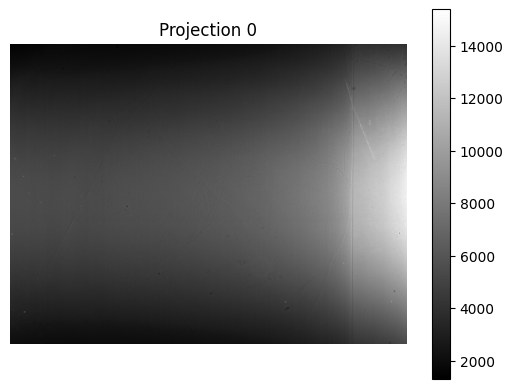

In [2]:
def display_slice(slice, title='Slice', cmap='gray', vmin=None, vmax=None, colorbar=False):
    """
    Display a slice with matplotlib dans un 1:1 aspect ratio

    Parameters
    ----------
    slice : numpy array
        Slice to display
    title : str
        Title of the plot
    cmap : str
        Color map to use

    Returns
    -------
    None
    
    """
    import matplotlib.pyplot as plt

    plt.imshow(slice, cmap=cmap, vmin=vmin, vmax=vmax)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')

    if colorbar:
        plt.colorbar()
        
    plt.title(title)

    plt.show()

display_slice(projs[0], title='Projection 0', cmap='gray', colorbar=True)

In [ ]:
### Get Center of Rotation from csv file


import pandas as pd
import os

csv_path = r"C:\Users\clement.capdeville\Documents\GitHub\SOLEIL25\part_info.csv"
part_info = pd.read_csv(csv_path)
filtered_info = part_info.loc[part_info["Path"] == os.path.basename(projs_path).split(".")[0]]
# CoR = filtered_info["CoR"].values[0] if not filtered_info.empty else None
# angle_padding = filtered_info["Angle"].values[0] if not filtered_info.empty else None

CoR = 287
print("CoR:", CoR)
# print("Angle padding:", angle_padding)

In [3]:
### Preprocessing

def flatfield_correction(proj, white, dark):
    """
    Apply flat-field correction to an image.

    Parameters
    ----------
    proj : 2D numpy array
        Image to correct
    white : 2D numpy array
        Whitefield image
    dark : 2D numpy array
        Darkfield image

    Returns
    -------
    I_corr : 2D numpy array
        Corrected image

    """
    numerator = abs(proj - dark)
    denominator = abs(white - dark)

    denominator[denominator == 0] = 1e-6

    return numerator / denominator

projs = flatfield_correction(projs, dark, flat)

delta/beta: 600.0


100%|██████████| 3600/3600 [03:22<00:00, 17.78it/s]


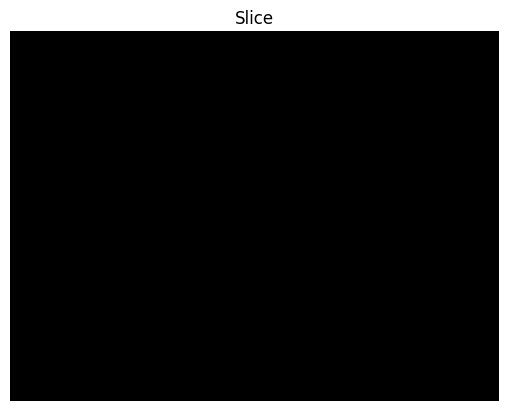

napari.manifest -> 'multipaganinproject' could not be imported: The name field in the manifest ('multipaganin-plugin') must match the package name ('multipaganinproject')


<Image layer 'Processed Projections' at 0x1f37bcc2090>

In [4]:
### Testing Paganin

import math
from scipy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift
from numpy import pi
import napari
import matplotlib.pyplot as plt
from tqdm import tqdm
import cupy as cp

def keVtoLambda(energy_kev):
    """
    Convert energy in keV to wavelength in m.

    Parameters
    ----------
    energy_kev : float
        Energy in keV

    Returns
    -------
    float
        Wavelength in m
    """
    h = 6.58211928e-19  # keV.s
    c = 299792458  # m/s
    return h * c / energy_kev

def get_padding_size(image, energy, effective_pixel_size, distance):
    """
    Calculate the padding size for a 2D image.

    Parameters
    ----------
    image : numpy.ndarray
        2D array of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).

    Returns
    -------
    n_margin : int
        Padding size.
    """
    ny, nx = image.shape
    wavelength = keVtoLambda(energy)

    # Calculate the padding size
    n_margin = math.ceil(3 * wavelength * distance / (2 * effective_pixel_size**2))
    
    nx_margin = nx + 2 * n_margin
    ny_margin = ny + 2 * n_margin

    nx_padded = 2 ** math.ceil(math.log2(nx_margin))
    ny_padded = 2 ** math.ceil(math.log2(ny_margin))


    return nx_padded, ny_padded

def padding(image, nx_padded, ny_padded):
    """
    Pad a 2D image to avoid edge artifacts during phase retrieval with the closest value.

    Parameters
    ----------
    image : numpy.ndarray
        2D array of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).

    Returns
    -------
    padded_image : numpy.ndarray
        Padded image.
    """
    
    ny, nx = image.shape

    top = (ny_padded - ny) // 2
    bottom = ny_padded - ny - top
    left = (nx_padded - nx) // 2
    right = nx_padded - nx - left

    return np.pad(image, ((top, bottom), (left, right)), mode='reflect')

def get_wave_number(energy_kev):
    """
    Get the wave number from the energy of the X-ray beam.

    Parameters
    ----------
    energy_kev : float
        Energy of the X-ray beam (keV).

    Returns
    -------
    float
        Wave number.
    """
    lambda_energy = keVtoLambda(energy_kev)
    return 2 * pi / lambda_energy

def get_mu(beta, wave_number):
    """
    Get the attenuation coefficient.

    Parameters
    ----------
    beta : float
        Beta value for phase retrieval.
    wave_number : float
        Wave number.

    Returns
    -------
    float
        Attenuation coefficient.
    """
    return 2 * beta * wave_number

def get_uv_sqrd(sample_images, pix_size):
    Nx, Ny = sample_images.shape

    u = cp.arange(0, Nx) - (Nx / 2)
    v = cp.arange(0, Ny) - (Ny / 2)

    u, v = cp.meshgrid(u, v, indexing='ij')
    u_m = u / (Nx * pix_size)
    v_m = v / (Ny * pix_size)

    return (u_m**2 + v_m**2)


def get_denominator(sample_images, energy_kev, pixel_size, delta_beta, dist_object_detector, beta=1e-10):
    """
    Get the denominator of the Paganin filter.

    Parameters
    ----------
    sample_images : numpy.ndarray
        Image to filter.
    energy_kev : float
        Energy of the X-ray beam (keV).
    pixel_size : float
        Effective pixel size of the detector (m).
    delta_beta : float
        Delta over beta value.
    dist_object_detector : float
        Distance between the object and the detector (m).
    beta : float
        Beta value for phase retrieval.

    Returns
    -------
    numpy.ndarray
        Denominator of the Paganin filter.
    """
    wave_number = get_wave_number(energy_kev)
    uv_sqrd = get_uv_sqrd(sample_images, pixel_size)
    
    denominator = 1 + pi * delta_beta * dist_object_detector * wave_number * uv_sqrd
    denominator[denominator == 0] = np.finfo(float).eps

    return denominator

def paganin_filter(sample_images, denominator, mu):
    fftNum = cp.fft.fftshift(cp.fft.fft2(sample_images))
    tmpThickness = cp.fft.ifft2(cp.fft.ifftshift(fftNum / denominator))
    img_thickness = cp.real(tmpThickness)
    img_thickness = cp.maximum(img_thickness, 1e-12)

    return (-cp.log(img_thickness) / mu) * 1e6


def process_projection(proj, nx_padded, ny_padded, denominator, mu):
    """
    Process a projection with the Paganin filter using CuPy (GPU).

    Parameters
    ----------
    proj : np.ndarray
        Single projection (2D NumPy array)
    nx_padded, ny_padded : int
        Padded dimensions
    denominator : cp.ndarray
        Precomputed Paganin denominator (on GPU)
    mu : float
        Attenuation coefficient

    Returns
    -------
    np.ndarray
        Paganin-filtered projection (2D NumPy array)
    """

    # Padding en NumPy → CuPy
    padded_proj = padding(proj, nx_padded, ny_padded)
    padded_proj_gpu = cp.asarray(padded_proj)

    # FFT + Paganin filter
    fftNum = cp.fft.fftshift(cp.fft.fft2(padded_proj_gpu))
    tmpThickness = cp.fft.ifft2(cp.fft.ifftshift(fftNum / denominator))
    img_thickness = cp.real(tmpThickness)
    img_thickness = cp.maximum(img_thickness, 1e-12)

    retrieved = (-cp.log(img_thickness) / mu) * 1e6

    # Crop
    nx, ny = proj.shape
    x_margin = (nx_padded - nx) // 2
    y_margin = (ny_padded - ny) // 2
    cropped_gpu = retrieved[x_margin:x_margin+nx, y_margin:y_margin+ny]

    return cp.asnumpy(cropped_gpu)


def process_volume(proj, energy, effective_pixel_size, distance, beta, delta, pixel_size):
    nx_padded, ny_padded = get_padding_size(proj[0], energy, effective_pixel_size, distance)

    padded_proj = padding(proj[0], nx_padded, ny_padded)  # still NumPy
    padded_proj_gpu = cp.asarray(padded_proj)

    mu = get_mu(beta, get_wave_number(energy))
    denominator = get_denominator(padded_proj_gpu, energy, pixel_size, delta/beta, distance, beta)

    projs_corrected = np.zeros_like(proj)

    for i in tqdm(range(proj.shape[0])):
        projs_corrected[i] = process_projection(proj[i], nx_padded, ny_padded, denominator, mu)

    return projs_corrected


energy = 40
effective_pixel_size = 10.4e-6 
distance = 1.2
pixel_size = 12e-6
delta = 7.8e-7
beta = 1.3e-9

nx = projs.shape[1]
ny = projs.shape[2]

print("delta/beta:", delta/beta)

retrieved_projs = process_volume(projs, energy, effective_pixel_size, distance, beta, delta, pixel_size)
display_slice(retrieved_projs[0])

viewer = napari.Viewer()
viewer.add_image(retrieved_projs, name='Processed Projections')

In [ ]:
viewer = napari.Viewer()
viewer.add_image(retrieved_projs, name='Projections')

In [ ]:
### Testing Paganin

import math
from scipy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift
from numpy import pi
import napari
import matplotlib.pyplot as plt
import cupy as cp

def keVtoLambda(energy_kev):
    """
    Convert energy in keV to wavelength in m.

    Parameters
    ----------
    energy_kev : float
        Energy in keV

    Returns
    -------
    float
        Wavelength in m
    """
    h = 6.58211928e-19  # keV.s
    c = 299792458  # m/s
    return h * c / energy_kev

def flatfield_correction(proj, white, dark):
    """
    Apply flat-field correction to an image.

    Parameters
    ----------
    proj : 2D numpy array
        Image to correct
    white : 2D numpy array
        Whitefield image
    dark : 2D numpy array
        Darkfield image

    Returns
    -------
    I_corr : 2D numpy array
        Corrected image

    """
    numerator = abs(proj - dark)
    denominator = abs(white - dark)

    denominator[denominator == 0] = 1e-6

    return numerator / denominator


def get_padding_size(image, energy, effective_pixel_size, distance):
    """
    Calculate the padding size for a 2D image.

    Parameters
    ----------
    image : numpy.ndarray
        2D array of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).

    Returns
    -------
    n_margin : int
        Padding size.
    """
    ny, nx = image.shape
    wavelength = keVtoLambda(energy)

    # Calculate the padding size
    n_margin = math.ceil(3 * wavelength * distance / (2 * effective_pixel_size**2))
    
    nx_margin = nx + 2 * n_margin
    ny_margin = ny + 2 * n_margin

    nx_padded = 2 ** math.ceil(math.log2(nx_margin))
    ny_padded = 2 ** math.ceil(math.log2(ny_margin))


    return nx_padded, ny_padded

def padding(image, nx_padded, ny_padded):
    """
    Pad a 2D image to avoid edge artifacts during phase retrieval with the closest value.

    Parameters
    ----------
    image : numpy.ndarray
        2D array of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).

    Returns
    -------
    padded_image : numpy.ndarray
        Padded image.
    """
    
    ny, nx = image.shape

    top = (ny_padded - ny) // 2
    bottom = ny_padded - ny - top
    left = (nx_padded - nx) // 2
    right = nx_padded - nx - left

    return cp.pad(image, ((top, bottom), (left, right)), mode='reflect')

def paganin_filter(sample_images, energy_kev, pixel_size, delta_beta, dist_object_detector, beta=1e-10):
    """
    Apply the Paganin filter to an image.

    Parameters
    ----------
    sample_images : numpy.ndarray
        Image to filter.
    energy_kev : float
        Energy of the X-ray beam (keV).
    pixel_size : float
        Effective pixel size of the detector (m).
    delta_beta : float
        Delta over beta value.
    dist_object_detector : float
        Distance between the object and the detector (m).
    beta : float
        Beta value for phase retrieval.

    Returns
    -------
    img_thickness : numpy.ndarray
        Filtered image.
    """
    lambda_energy = keVtoLambda(energy_kev)
    pix_size = pixel_size

    waveNumber = 2 * pi / lambda_energy

    mu = 2 * beta * waveNumber

    fftNum = fftshift(fft2(sample_images))
    Nx, Ny = fftNum.shape

    u = fftfreq(Nx, d=pix_size)
    v = fftfreq(Ny, d=pix_size)

    u, v = cp.meshgrid(cp.arange(0,Nx), cp.arange(0,Ny))
    u = u - (Nx/2)
    v = v - (Ny/2)
    u_m = u / (Nx * pix_size) 
    v_m = v / (Ny * pix_size)
    uv_sqrd = cp.transpose(u_m**2 + v_m**2)

    denominator = 1 + pi * delta_beta * dist_object_detector * lambda_energy * uv_sqrd
    denominator[denominator == 0] = cp.finfo(float).eps

    tmpThickness = ifft2(ifftshift(fftNum / denominator))
    img_thickness = cp.real(tmpThickness)
    img_thickness[img_thickness <= 0] = 0.000000000001

    return (-cp.asnumpy(cp.log(img_thickness) / mu) * 100)


def process_projection(proj, nx, ny, white, dark, energy, effective_pixel_size, distance, beta, delta, pixel_size):
        """
        Process a single projection image.

        Parameters
        ----------
        proj : numpy.ndarray
            Projection image.
        nx : int
            Width of the image.
        ny : int
            Height of the image.
        white : numpy.ndarray
            Whitefield image.
        dark : numpy.ndarray
            Darkfield image.
        energy : float
            Energy of the X-ray beam (keV).
        effective_pixel_size : float
            Effective pixel size of the detector (m).
        distance : float
            Distance between the object and the detector (m).
        beta : float
            Beta value for phase retrieval.
        delta : float
            Delta value for phase retrieval.
        pixel_size : float
            Detector pixel size (m).

        Returns
        -------
        numpy.ndarray
            Processed image.
        """
        
        corrected_proj = flatfield_correction(cp.asarray(proj), cp.asarray(white), cp.asarray(dark))
        padded_proj, ny_padded, nx_padded = padding(corrected_proj, energy, effective_pixel_size, distance)
        retrieved_proj = paganin_filter(padded_proj, energy, pixel_size, delta/beta, distance, beta)
        x_margin = abs(nx_padded - nx) // 2
        y_margin = abs(ny_padded - ny) // 2

        return retrieved_proj[x_margin:x_margin+nx, y_margin:y_margin+ny]


energy = 40
effective_pixel_size = 10.4e-6 
distance = 1.2
pixel_size = 12e-6
delta = 7.8e-7
beta = 1.3e-9

nx = projs.shape[1]
ny = projs.shape[2]

print("delta/beta:", delta/beta)

proj = process_projection(projs[0], 
                          nx, 
                          ny, 
                            flat,
                            dark,
                          energy, 
                          effective_pixel_size, 
                          distance, 
                          beta, 
                          delta, 
                          pixel_size)
display_slice(proj)

viewer = napari.Viewer()
viewer.add_image(proj, name='Processed Projections')

In [ ]:
### Apply Paganin to all projections

from tqdm import tqdm
from joblib import Parallel, delayed


retrieved_projs = np.array(Parallel(n_jobs=-1, backend='threading')(
    delayed(process_projection)(proj, nx, ny, flat, dark, energy, effective_pixel_size, distance, beta, delta, pixel_size) 
    for proj in tqdm(projs)))

display_slice(retrieved_projs[0])

In [ ]:
import napari

napari.view_image(retrieved_projs)

In [ ]:
### Double Flatfield Correction

def double_flatfield_correction(projs):
    """
    Apply double flat-field correction to an image.

    Parameters
    ----------
    proj : 2D numpy array
        Image to correct

    Returns
    -------
    I_corr : 2D numpy array
        Corrected image

    """

    mean_proj = np.mean(projs, axis=0)

    mean_proj[mean_proj == 0] = 1e-6

    I_corr = projs / mean_proj

    return I_corr


double_flatfield_projs = double_flatfield_correction(retrieved_projs)


In [ ]:
import numpy as np

double_flatfield_projs = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_double_flatfield_projs.npy")

In [ ]:
6.8e-7/2e-9

In [ ]:
min = np.min(double_flatfield_projs)
max = np.max(double_flatfield_projs)

print(min, max)

normed_projs = (double_flatfield_projs - min) / (max - min)

In [ ]:
from tqdm import tqdm

def normalize_proj_mean(projs):

    global_mean = np.mean([np.mean(proj) for proj in projs])
    print("Global mean:", global_mean)

    normalized_proj = []
    for proj in tqdm(projs, desc="Normalizing projections"):
        mean = np.mean(proj)
        if mean == 0:
            mean = 1
        normalized_proj.append(proj * global_mean / mean)

    return np.array(normalized_proj)

normed_projs = normalize_proj_mean(double_flatfield_projs)

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(double_flatfield_projs, name='Projections')
viewer.add_image(normed_projs, name='Normed Projections')

In [ ]:
### Retrieve the sinogram

from joblib import Parallel, delayed
from tqdm import tqdm
import gc
import napari

import numpy as np

def apply_left_weighting(projs, CoR):
    """
    Applique un poids linéaire sur la partie gauche des projections.
    """
    # Générer les poids de manière efficace
    weights = np.linspace(0, 1, CoR)[None, None, :]  # Ajout des dimensions pour le broadcasting
    
    # Appliquer le poids directement par broadcasting (évite np.tile)
    projs[:, :, :CoR] *= weights

    return projs  # Retourne le tableau modifié en place
   

def create_sinogram_slice(projs, CoR, slice_idx):
    """
    Create a sinogram from a set of projections.
    """
    theta, nx, ny = projs.shape

    sino = np.zeros((theta//2, 2 * ny - CoR))

    flip = projs[:theta // 2, slice_idx, ::-1]  # np.flip optimisé
    
    sino[:, :ny] += flip
    sino[:,  -ny:] += projs[theta//2:, slice_idx, :]

    return sino

def create_sinogram(projs, CoR):
    """
    Create sinograms from a set of projections.
    """

    projs_weighted = apply_left_weighting(projs, CoR)

    sinos = np.array(
        Parallel(n_jobs=-1, backend='threading')(
            delayed(create_sinogram_slice)(projs_weighted, CoR, slice_idx)
            for slice_idx in tqdm(range(projs.shape[1]), desc='Creating sinograms')
        )
    )

    return sinos
CoR = 287
sinogram = create_sinogram(retrieved_projs, round(CoR))
print("Sinogram shape:", sinogram.shape)

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(sinogram, name='Sinogram')

In [ ]:
import tifffile

tifffile.imwrite(r"C:\Users\clement.capdeville\Desktop\test2.tif", sinogram[50].astype(np.float32), imagej=True)

In [ ]:
import numpy as np
from numpy import pi

def from_degress_to_radians(angles):
    return angles * pi / 180

def from_radians_to_degrees(angles):
    return angles * 180 / pi

# angles = from_degress_to_radians(np.linspace(0, (sinogram.shape[1] - 1) * angle_padding, sinogram.shape[1], endpoint=False))
angles = np.linspace(0, pi, sinogram.shape[1], endpoint=False)

print("Angles shape:", angles)


In [ ]:
### Reconstruction

from skimage.draw import disk
import astra

def reconstruct_from_sinogram_slice(sinogram, angles):
    """
    Reconstruct a 2D image from a sinogram using FBP_CUDA algorithm from ASTRA Toolbox.

    Parameters:
    - sinogram: 2D numpy array (angles, detectors) containing the sinogram.
    - angles: 1D numpy array of rotation angles (in radians).

    Returns:
    - reconstruction: 2D numpy array representing the reconstructed image.
    """

    # Définition des géométries de projection et du volume
    proj_geom = astra.create_proj_geom('parallel', 1.0, sinogram.shape[1], angles)
    vol_geom = astra.create_vol_geom(sinogram.shape[1], sinogram.shape[1])

    # Création des objets de données pour le sinogramme et la reconstruction
    sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Configuration et exécution de l'algorithme FBP_CUDA
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    # Récupération et retour de la reconstruction
    reconstruction = astra.data2d.get(rec_id)

    # Libération des ressources ASTRA
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)

    return reconstruction

disk_mask = np.zeros((sinogram.shape[2], sinogram.shape[2]))
rr, cc = disk((sinogram.shape[2]//2, sinogram.shape[2]//2), sinogram.shape[2] // 2)
disk_mask[rr, cc] = 1

from tqdm import tqdm
import napari

reconstruction = np.zeros((50, sinogram.shape[2], sinogram.shape[2]))
for i in tqdm(range(50), desc='Reconstructing'):
    reconstruction[i] = reconstruct_from_sinogram_slice(sinogram[500+i], angles) * disk_mask
viewer = napari.view_image(reconstruction)
print("Reconstruction shape:", reconstruction.shape)

In [ ]:
### Save tiff format

import tifffile

tifffile.imwrite(r"C:\Users\clement.capdeville\Desktop\tooth.tif", reconstruction.astype(np.float32), imagej=True)